In [1]:
#import keras

In [50]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

In [51]:
#review = pd.read_csv("InputModel.csv", error_bad_lines=False, encoding="ISO-8859-1")


Data=pd.read_csv("consumer_complaints.csv", error_bad_lines=False, encoding="ISO-8859-1")

review.head()

,product,issue,label,text
0,Mortgage,"loanmodification,collection,foreclosure",6,"loanmodification,collection,foreclosure"
1,Mortgage,"loanservicing,payments,escrowaccount",6,"loanservicing,payments,escrowaccount"
2,Credit reporting,incorrectinformationoncreditreport,3,incorrectinformationoncreditreport
3,Student loan,repayingyourloan,10,repayingyourloan
4,Debt collection,falsestatementsorrepresentation,4,falsestatementsorrepresentation


In [52]:
review=Data[["product","issue"]]

In [8]:
review.head()

,product,issue
0,Mortgage,"Loan modification,collection,foreclosure"
1,Mortgage,"Loan servicing, payments, escrow account"
2,Credit reporting,Incorrect information on credit report
3,Student loan,Repaying your loan
4,Debt collection,False statements or representation


In [13]:
#deskJanApr = deskJanApr[['Date', 'text', 'New bucket']]
#deskJanApr['New bucket'] = deskJanApr['New bucket'].str.lower()
#deskJanApr['New bucket'] = deskJanApr['New bucket'].str.replace(" ", "")
#deskJanApr['New bucket'] = deskJanApr['New bucket'].str.strip()


In [14]:
#deskJanApr.head()

In [15]:
#Currenlty we are keeping all the N/As as a category, in pandas are labled as blank
#review_2 = review_2[review_2['Theme'] != 'blank']

In [53]:
review['issue'] = review['issue'].str.lower()
review['issue'] = review['issue'].str.replace(" ", "")
review['issue'] = review['issue'].str.strip()
review = review[review['issue'] != '??']
review = review[review['issue'] != '']

In [18]:
review.columns

Index(['product', 'issue'], dtype='object')

In [54]:
review["text"]=review["issue"]

In [57]:
review["label"]=review["product"].astype('category').cat.codes




In [56]:
combinedComments=review[["text","label",'product']]

In [30]:
combinedComments.head()

,text,label,product
0,"loanmodification,collection,foreclosure",6,Mortgage
1,"loanservicing,payments,escrowaccount",6,Mortgage
2,incorrectinformationoncreditreport,3,Credit reporting
3,repayingyourloan,10,Student loan
4,falsestatementsorrepresentation,4,Debt collection


In [58]:
val_data=combinedComments.sample(frac=0.1,random_state=11)
train_data=combinedComments.drop(val_data.index)


In [59]:
train_data[0:5]

,text,label,product
0,"loanmodification,collection,foreclosure",6,Mortgage
1,"loanservicing,payments,escrowaccount",6,Mortgage
2,incorrectinformationoncreditreport,3,Credit reporting
3,repayingyourloan,10,Student loan
4,falsestatementsorrepresentation,4,Debt collection


In [60]:
val_data = val_data.reset_index()

train_data = train_data.reset_index()
#val_data.to_csv('val_data.csv')

In [61]:
train = train_data[[ 'text', 'product', 'label']]
val = val_data[[ 'text', 'product', 'label']]
val = val.replace('nan', '', regex=True)
train = train.replace('nan', '', regex=True)

In [62]:
val.head(2)

,text,product,label
0,aprorinterestrate,Credit card,2
1,"loanservicing,payments,escrowaccount",Mortgage,6


In [63]:
from nltk.stem import WordNetLemmatizer
import re
import string

from nltk.stem import SnowballStemmer
from string import punctuation

In [64]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 2]
    
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"other", "", text)

    ## Stemming
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lem_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lem_words)

    return text



In [65]:
len((train['product']).unique())

11

In [39]:
#balanceData = balanceData.groupby('New bucket').filter(lambda balanceData: len(balanceData) > 40)

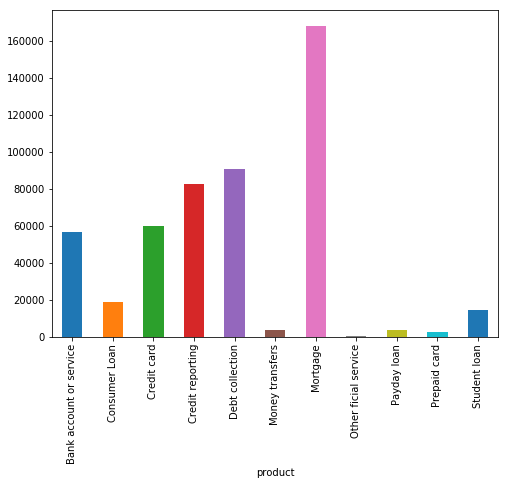

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,6))
train.groupby('product').text.count().plot.bar(ylim=0)
plt.show()

In [41]:
#balanceData["label"]=balanceData["New bucket"].astype('category').cat.codes

In [44]:
 val.head()

,Date,text,New bucket,label
0,01/28/2018,markna,notapplicable,12
1,06/11/2018,markna,notapplicable,12
2,04/26/2018,tell promo would lose downgrading bundle cost ...,product:content,25
3,02/23/2018,markna,notapplicable,12
4,06/09/2018,list service available website let customer lo...,function:notuser-friendly,8


In [67]:
#Tokenize text of the training data with keras text preprocessing functions
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout

from keras.optimizers import Adam

In [68]:
MAX_SEQUENCE_LENGTH = 250
MAX_VOCAB_SIZE = 30000
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
#tokenizer1 = Tokenizer(num_words=MAX_VOCAB_SIZE,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)

In [168]:
tokenizer.fit_on_texts(review.text)
sequences_train = tokenizer.texts_to_sequences(review.text)

#tokenizer.fit_on_texts(review.product)
#sequences_label = tokenizer.texts_to_sequences(review.product)


tokenizer.fit_on_texts(val.text)
sequences_valid=tokenizer.texts_to_sequences(val.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 127 unique tokens.


In [ ]:
#This vectorization allows code to efficiently perform the matrix operations in batch for your chosen deep learning algorithms.

In [194]:
X_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
X_newVal = pad_sequences(sequences_valid,maxlen=MAX_SEQUENCE_LENGTH)
#y_train = to_categorical(np.asarray(train.label))
#y_train = pad_sequences(train.label,maxlen=MAX_SEQUENCE_LENGTH)
y_train = to_categorical(np.asarray(review.label))

#y_train = np.asarray(train.label)


y_val = to_categorical(np.asarray(val.label))
print('Shape of X train and X validation tensor:', X_train.shape,X_newVal.shape)
print('Shape of label train and validation tensor:', y_train.shape)

Shape of X train and X validation tensor: (555957, 250) (55596, 250)
Shape of label train and validation tensor: (555957, 11)


In [176]:
X_train = pad_sequences(sequences_train)
X_newVal = pad_sequences(sequences_valid)
y_train = to_categorical(np.asarray(train.label))
y_val = to_categorical(np.asarray(val.label))
print('Shape of X train and X validation tensor:', X_train.shape,X_newVal.shape)
print('Shape of label train and validation tensor:', y_train.shape)

Shape of X train and X validation tensor: (555957, 3) (55596, 3)
Shape of label train and validation tensor: (500361, 11)


In [76]:
word2vec = {}
f = open('/Users/mismael/Downloads/glove.42B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word2vec[word] = coefs
f.close()
print('Found %s word vectors.' % len(word2vec))

Found 1917494 word vectors.


In [79]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector



Filling pre-trained embeddings...


In [106]:
embedding_layer



In [81]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False)

In [239]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          38400     
_________________________________________________________________
dense_43 (Dense)             (None, 250, 11)           3311      
Total params: 41,711
Trainable params: 3,311
Non-trainable params: 38,400
_________________________________________________________________


In [255]:
model1 = Sequential()
model1.add(embedding_layer)
model1.add(Dense(30,  activation='relu'))
model1.add(LSTM(100))
model1.add(Dense(11, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.fit(X_train, y_train , epochs=3)

Epoch 1/3
555957/555957 [==============================] - 3474s 6ms/step - loss: 0.8443 - acc: 0.6850
Epoch 2/3
555957/555957 [==============================] - 3327s 6ms/step - loss: 0.8391 - acc: 0.6864
Epoch 3/3
555957/555957 [==============================] - 3883s 7ms/step - loss: 0.8387 - acc: 0.6865


In [252]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          38400     
_________________________________________________________________
dense_54 (Dense)             (None, 250, 30)           9030      
_________________________________________________________________
dense_55 (Dense)             (None, 250, 11)           341       
Total params: 47,771
Trainable params: 9,371
Non-trainable params: 38,400
_________________________________________________________________


In [244]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          38400     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 250, 100)          120100    
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 62, 100)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_32 (Dense)             (None, 11)                1111      
Total params: 240,011
Trainable params: 201,611
Non-trainable params: 38,400
_________________________________________________________________


In [235]:
predict1 = model1.predict(X_newVal,verbose=1)
classes1 = predict1.argmax(axis=1)
df2 =(pd.DataFrame(classes1))
accuracy1 = accuracy_score(df2, actual)

55596/55596 [==============================] - 1s 20us/step


In [256]:
accuracy1

print(classification_report(actual, df2))

             precision    recall  f1-score   support

          0       0.61      0.51      0.56      6240
          1       0.00      0.00      0.00      2105
          2       0.52      0.64      0.57      6723
          3       0.62      0.73      0.67      9257
          4       0.43      0.59      0.49     10225
          5       0.00      0.00      0.00       352
          6       1.00      0.92      0.96     18428
          7       0.00      0.00      0.00        49
          8       0.45      0.05      0.09       369
          9       1.00      0.66      0.79       238
         10       0.00      0.00      0.00      1610

avg / total       0.65      0.67      0.65     55596



In [200]:
## create model
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train ,  epochs = 3)

## Fit train data
#model_glove.fit(X_train, labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          38400     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 250, 100)          120100    
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 62, 100)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_32 (Dense)             (None, 11)                1111      
Total params: 240,011
Trainable params: 201,611
Non-trainable params: 38,400
_________________________________________________________________
None
Epoch 1/3
555957/555957 [==============================] - 1990s 4ms/step - loss: 0.8426 - acc: 0.6854
Epoch 2/3
555957/555957

In [201]:
predict = model.predict(X_newVal,verbose=1)
classes = predict.argmax(axis=1)
df1 =(pd.DataFrame(classes))
actual = val.label.values

55596/55596 [==============================] - 62s 1ms/step


In [203]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [213]:
actual

array([2, 6, 0, ..., 6, 6, 6])

In [215]:
accuracy = accuracy_score(df1, actual)
accuracy

0.6847255198215699

In [218]:
print(classification_report(actual, df1))

             precision    recall  f1-score   support

          0       0.86      0.51      0.64      6240
          1       0.00      0.00      0.00      2105
          2       0.84      0.33      0.48      6723
          3       0.36      1.00      0.53      9257
          4       1.00      0.48      0.65     10225
          5       1.00      0.03      0.06       352
          6       1.00      0.94      0.97     18428
          7       1.00      0.12      0.22        49
          8       0.00      0.00      0.00       369
          9       1.00      0.74      0.85       238
         10       0.90      0.62      0.74      1610

avg / total       0.81      0.68      0.68     55596



array([[ 3185,     0,     0,  3055,     0,     0,     0,     0,     0,
            0,     0],
       [    0,     0,     0,  2095,     0,     0,     0,     0,     0,
            0,    10],
       [  506,     0,  2247,  3970,     0,     0,     0,     0,     0,
            0,     0],
       [    0,     0,     0,  9257,     0,     0,     0,     0,     0,
            0,     0],
       [    0,     0,     0,  5357,  4868,     0,     0,     0,     0,
            0,     0],
       [    0,     0,     0,   341,     0,    11,     0,     0,     0,
            0,     0],
       [    0,     0,   421,   694,     0,     0, 17313,     0,     0,
            0,     0],
       [    0,     0,    18,    25,     0,     0,     0,     6,     0,
            0,     0],
       [    0,     0,     0,   271,     0,     0,     0,     0,     0,
            0,    98],
       [    0,     0,     0,    63,     0,     0,     0,     0,     0,
          175,     0],
       [    0,     0,     0,   604,     0,     0,     0,    

In [221]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [222]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Loaded model from disk


In [223]:
predict = loaded_model.predict(X_newVal,verbose=1)
classes = predict.argmax(axis=1)
df1 =(pd.DataFrame(classes))
actual = val.label.values
df1.columns= ['pred']
accuracy = accuracy_score(df1['pred'], actual)
accuracy

55596/55596 [==============================] - 62s 1ms/step


0.6847255198215699

In [224]:
val_data.to_csv("pred_new.csv")

In [ ]:
model.add(Dense(30, input_dim=11, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(np.array(X_train), np.array(Y_train), epochs=50, batch_size=200, shuffle=True)